In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras import optimizers
from sklearn.model_selection import train_test_split
from skimage.io import imread
base_skin_dir = os.path.join('..', 'cancer_classifier')

Using TensorFlow backend.


In [2]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
imageid_path_dict

{'ISIC_0026784': '../cancer_classifier/HAM10000_images_part_1/ISIC_0026784.jpg',
 'ISIC_0028971': '../cancer_classifier/HAM10000_images_part_1/ISIC_0028971.jpg',
 'ISIC_0026948': '../cancer_classifier/HAM10000_images_part_1/ISIC_0026948.jpg',
 'ISIC_0026790': '../cancer_classifier/HAM10000_images_part_1/ISIC_0026790.jpg',
 'ISIC_0028965': '../cancer_classifier/HAM10000_images_part_1/ISIC_0028965.jpg',
 'ISIC_0025299': '../cancer_classifier/HAM10000_images_part_1/ISIC_0025299.jpg',
 'ISIC_0024839': '../cancer_classifier/HAM10000_images_part_1/ISIC_0024839.jpg',
 'ISIC_0024811': '../cancer_classifier/HAM10000_images_part_1/ISIC_0024811.jpg',
 'ISIC_0026960': '../cancer_classifier/HAM10000_images_part_1/ISIC_0026960.jpg',
 'ISIC_0028795': '../cancer_classifier/HAM10000_images_part_1/ISIC_0028795.jpg',
 'ISIC_0026974': '../cancer_classifier/HAM10000_images_part_1/ISIC_0026974.jpg',
 'ISIC_0028781': '../cancer_classifier/HAM10000_images_part_1/ISIC_0028781.jpg',
 'ISIC_0028959': '../cancer_

In [3]:
df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../cancer_classifier/HAM10000_images_part_2/IS...,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0


In [4]:
df.to_csv('cancercell.csv', index=False)

In [2]:
df= pd.read_csv('cancercell.csv')
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../cancer_classifier/HAM10000_images_part_2/IS...,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0


In [5]:
df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0001863,ISIC_0026244,nv,histo,male,back,../cancer_classifier/HAM10000_images_part_1/IS...,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


In [6]:
df['cell_type'].unique()

array(['Benign keratosis-like lesions ', 'Melanocytic nevi',
       'Dermatofibroma', 'dermatofibroma', 'Vascular lesions',
       'Basal cell carcinoma', 'Actinic keratoses'], dtype=object)

In [7]:
df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [3]:
df['age'].fillna((df['age'].mean()), inplace=True)
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

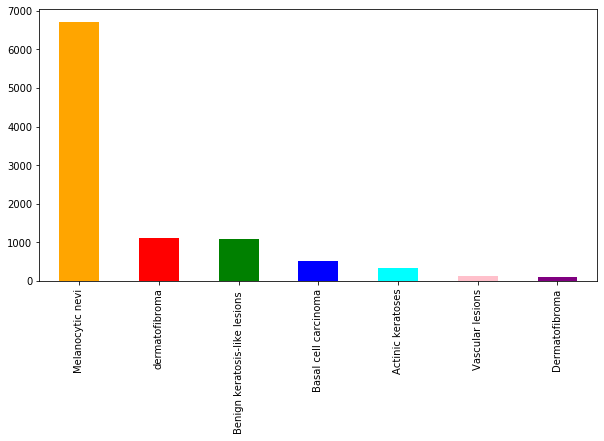

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
df['cell_type'].value_counts().plot(kind='bar', color=['orange', 'red', 'green', 'blue', 'cyan', 'pink', 'purple'])

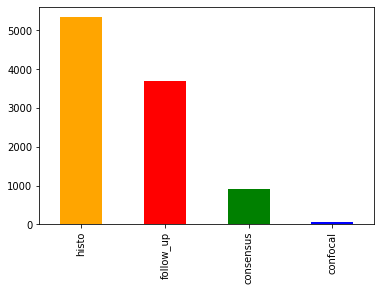

In [10]:
df['dx_type'].value_counts().plot(kind='bar', color=['orange', 'red', 'green', 'blue'])

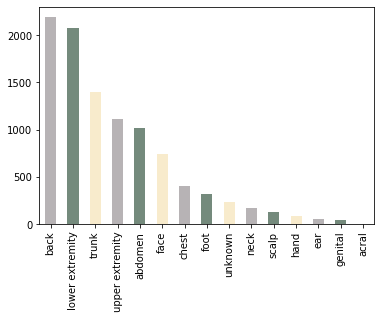

In [11]:
df['localization'].value_counts().plot(kind='bar', color=np.random.rand(3,4))

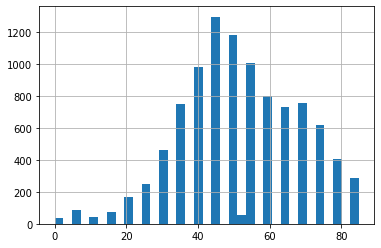

In [12]:
df['age'].hist(bins=35)

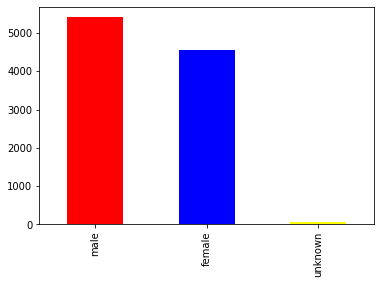

In [13]:
df['sex'].value_counts().plot(kind='bar', color=['red', 'blue', 'yellow'])

In [ ]:
df.head()

In [16]:
df.dtypes

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
image             object
dtype: object

In [4]:
# load in all of the images
df['image'] = df['path'].map(imread)
df['image'].map(lambda x: x.shape).value_counts()

(450, 600, 3)    10015
Name: image, dtype: int64

#### Show off a few in each category

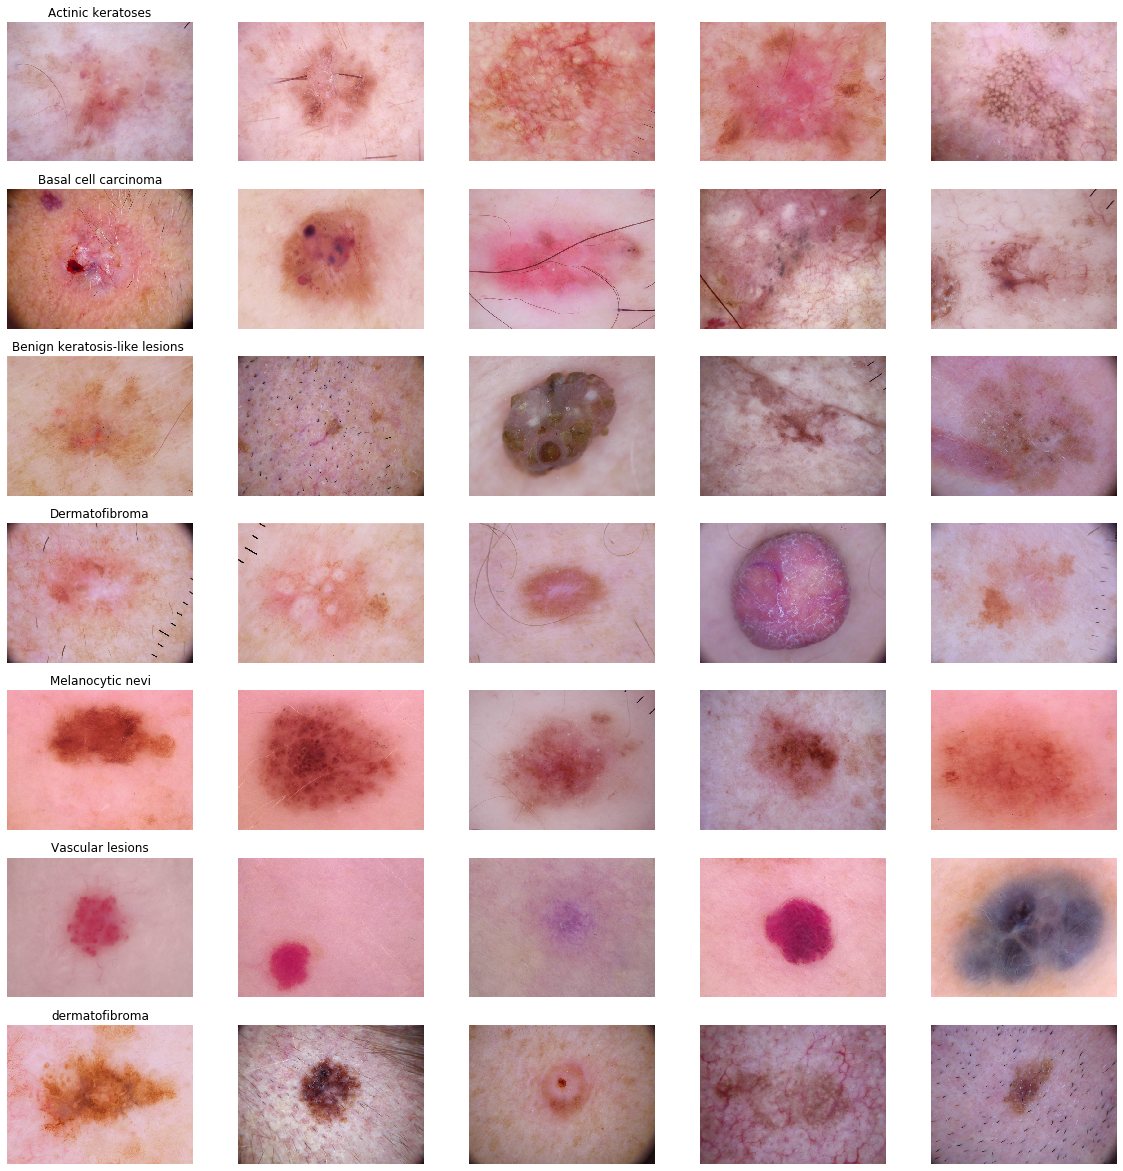

In [5]:
# load in all of the images
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

## Preparing for test train split

In [5]:
x= df.drop(columns=['cell_type_idx'], axis=1)
target= df['cell_type_idx']

In [6]:
x_train, x_test, y_train, y_test= train_test_split(x, target, test_size=0.20)

In [8]:
print('X_train shape: ', x_train.shape)
print('X_test shape: ', x_test.shape)
print('Y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (8012, 10)
X_test shape:  (2003, 10)
Y_train shape:  (8012,)
y_test shape:  (2003,)


In [10]:
x_train.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,image
6366,HAM_0002415,ISIC_0026121,nv,follow_up,30.0,female,trunk,../cancer_classifier/HAM10000_images_part_1/IS...,Melanocytic nevi,"[[[244, 152, 165], [244, 154, 166], [241, 153,..."
3653,HAM_0001993,ISIC_0029848,nv,follow_up,45.0,female,back,../cancer_classifier/HAM10000_images_part_2/IS...,Melanocytic nevi,"[[[244, 168, 170], [244, 168, 172], [250, 171,..."
5999,HAM_0003740,ISIC_0026568,nv,follow_up,55.0,male,trunk,../cancer_classifier/HAM10000_images_part_1/IS...,Melanocytic nevi,"[[[213, 129, 142], [214, 130, 145], [213, 129,..."
8024,HAM_0003649,ISIC_0033153,nv,histo,45.0,unknown,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Melanocytic nevi,"[[[151, 153, 176], [158, 153, 183], [154, 156,..."
3132,HAM_0002317,ISIC_0027268,nv,follow_up,45.0,female,upper extremity,../cancer_classifier/HAM10000_images_part_1/IS...,Melanocytic nevi,"[[[220, 141, 144], [228, 152, 156], [227, 150,..."


Normalization of features 

## Do NOT run this for normalization. Too expensive and often crashes
x_train = np.asarray(x_train['image'].tolist())

x_train_mean = np.mean(x_train)

x_train_std = np.std(x_train)

x_train = (x_train - x_train_mean)/x_train_std


x_test = np.asarray(x_test['image'].tolist())

x_test_mean = np.mean(x_test)

x_test_std = np.std(x_test)

x_test = (x_test - x_test_mean)/x_test_std


x_train.shape

#save the numpy arrays so can be loaded easier

np.save('x_train', x_train)

np.save('x_test', x_test)


Perform one-hot encoding on the labels

y_train = to_categorical(y_train, num_classes = 7)

y_test = to_categorical(y_test, num_classes = 7)


#load numpy files if kernels keep crashing

x_train= np.load('x_train.npy', allow_pickle=True)

x_test= np.load('x_test.npy', allow_pickle=True)


x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1)

x_train[0].shape

## Creation of Model

In [24]:
input_shape = (75, 100, 3)
num_classes = 7

In [38]:
model= Sequential()
model.add(Convolution2D(32,(3,3), input_shape=input_shape, activation='relu'))
model.add(Convolution2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(.3))

model.add(Convolution2D(64,(3,3), input_shape=input_shape, activation='relu'))
model.add(Convolution2D(64,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(64,(3,3), input_shape=input_shape, activation='relu'))
model.add(Convolution2D(64,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()



Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 73, 98, 32)        896       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 73, 98, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 49, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 36, 49, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 34, 47, 64)        18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 45, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 22, 64)       

Optimizer

In [40]:
optimizer= keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [41]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [45]:
# Set a learning rate annealer
lr_reduction = ReduceLROnPlateau(monitor='val_acc', #checks validation accuracy
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

Augmentation of training data

In [84]:
data= ImageDataGenerator(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  height_shift_range = 0.1, 
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True)

data.fit(x_train)                         

ValueError: could not convert string to float: 'HAM_0001607'

In [89]:
epochs = 50 
batch_size = 10
history = model.fit_generator(x_train,y_train,
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1
                              , callbacks=[lr_reduction])

ValueError: Error when checking input: expected conv2d_15_input to have 4 dimensions, but got array with shape (1127, 10)

In [99]:
BASE_MODEL='RESNET52' # ['VGG16', 'RESNET52', 'InceptionV3', 'Xception', 'DenseNet169', 'DenseNet121']
IMG_SIZE = (224, 224) # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 64 # [1, 8, 16, 24]
DROPOUT = 0.5
DENSE_COUNT = 128
LEARN_RATE = 1e-4
EPOCHS = 15

In [100]:
from keras.preprocessing.image import ImageDataGenerator
if BASE_MODEL=='RESNET52':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input

In [101]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  brightness_range = [0.5, 1.5],
                  horizontal_flip = True, 
                  vertical_flip = True,
              preprocessing_function = preprocess_input)
valid_args = dict(fill_mode = 'reflect',
                  preprocessing_function = preprocess_input)

core_idg = ImageDataGenerator(**dg_args)
valid_idg = ImageDataGenerator(**valid_args)

In [109]:
def flow_from_dataframe(img_data_gen, in_df, y_col, **dflow_args):
    base_dir = base_skin_dir
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df.values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [110]:
train_gen = flow_from_dataframe(core_idg, x_train, 
                            y_col = 'target_vec', 
                            target_size = IMG_SIZE,
                            batch_size = BATCH_SIZE)

# used a fixed dataset for evaluating the algorithm
valid_x, valid_y = next(flow_from_dataframe(valid_idg, 
                               valid_df, 
                            y_col = 'target_vec', 
                            target_size = IMG_SIZE,
                            batch_size = VALID_IMG_COUNT)) # one big batch
print(valid_x.shape, valid_y.shape)

## Ignore next message from keras, values are replaced anyways
Found 10015 images belonging to 5 classes.


KeyError: 'target_vec'